###  MicroGrad demo

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
#from micrograd.engine import Value
#from micrograd.nn import Neuron, Layer, MLP
from littlegrad2.engine import Tensor

In [11]:
np.random.seed(1337)
random.seed(1337)

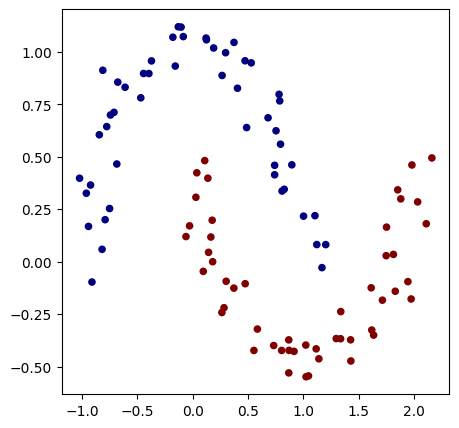

In [12]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [13]:
# initialize a model 
#model = MLP(2, [16, 16, 1]) # 2-layer neural network
#print(model)
#print("number of parameters", len(model.parameters()))

class LinearNet:
  def __init__(self):
    self.params = {
      'w1' : Tensor(2 * np.random.random_sample((2, 16)) - 1),
      'b1' : Tensor(np.zeros((1, 16))),
      'w2' : Tensor(2 * np.random.random_sample((16, 16)) - 1),
      'b2' : Tensor(np.zeros((1, 16))),
      'w3' : Tensor(2 * np.random.random_sample((16, 1)) - 1),
      'b3' : Tensor(np.zeros((1, 1)))
    }

  def parameters(self):
    return self.params.values()
  
  def zero_grad(self):
    for param in self.params.values():
        param.grad *= 0

  def __call__(self, x:Tensor) -> Tensor:
    return ((x@self.params['w1']+self.params['b1']).relu()@self.params['w2']+self.params['b2']).relu()@self.params['w3']+self.params['b3']
  
model = LinearNet()

In [14]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    #inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    #scores = list(map(model, inputs))
    scores = list(map(model, [Tensor(xi) for xi in Xb]))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p.flatten()@p.flatten().transpose() for p in model.parameters()))
    total_loss = data_loss + reg_loss
    #total_loss = sum(losses) * (1.0 / len(losses))
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Tensor object with data [[1.58106339]] [[0.48]]


In [15]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    #model.zero_grad()
    #total_loss.backward()
    total_loss.backprop()
    
    # update (sgd)
    #learning_rate = 1.0 - 0.9*k/100
    learning_rate = 0.01
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss [[1.58106339]], accuracy [[48.]]%
step 1 loss [[1.49365484]], accuracy [[48.]]%
step 2 loss [[1.32389669]], accuracy [[48.]]%
step 3 loss [[1.0820986]], accuracy [[51.]]%
step 4 loss [[0.81936741]], accuracy [[66.]]%
step 5 loss [[0.58329299]], accuracy [[83.]]%
step 6 loss [[0.45040592]], accuracy [[84.]]%
step 7 loss [[0.49154438]], accuracy [[78.]]%
step 8 loss [[0.52817831]], accuracy [[79.]]%
step 9 loss [[0.55052864]], accuracy [[78.]]%
step 10 loss [[0.55705064]], accuracy [[79.]]%
step 11 loss [[0.54946867]], accuracy [[79.]]%
step 12 loss [[0.53288765]], accuracy [[80.]]%
step 13 loss [[0.50456675]], accuracy [[81.]]%
step 14 loss [[0.47149769]], accuracy [[81.]]%
step 15 loss [[0.4405634]], accuracy [[84.]]%
step 16 loss [[0.41853935]], accuracy [[85.]]%
step 17 loss [[0.39458938]], accuracy [[85.]]%
step 18 loss [[0.37767741]], accuracy [[86.]]%
step 19 loss [[0.36258389]], accuracy [[87.]]%
step 20 loss [[0.34922364]], accuracy [[86.]]%
step 21 loss [[0.33515247

(-1.548639298268643, 1.951360701731357)

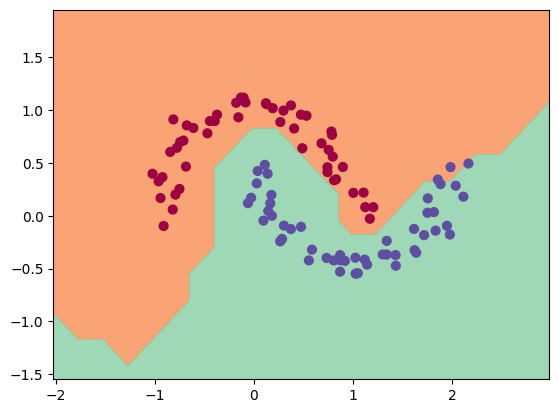

In [16]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
#inputs = [list(map(Value, xrow)) for xrow in Xmesh]
#scores = list(map(model, inputs))
scores = list(map(model, [Tensor(xi) for xi in Xmesh]))

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
